In [12]:
import os
import torch
from torch import nn
from poutyne import Model, CSVLogger
from poutyne.framework import ModelCheckpoint, EarlyStopping, plot_history
import numpy as np
import torchmetrics
from datetime import datetime
import sys
import pandas as pd
from custom_lib.custom_model import NeuralNetwork
from custom_lib.data_prep import data_transformation_pipeline, data_loader
import matplotlib as plt
import torchvision.models as models
import time


In [22]:
# Tuneable Params
lr = 1e-3

data_dir = "data"

# Define a model name (e.g., "model1")
model_name = "efficientnet_b0"

save_logs = True

epochs = 1

image_size = 224
rotate_angle=None
horizontal_flip_prob=None
brightness_contrast=None
gaussian_blur=None
normalize=False

In [3]:

if save_logs == True:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

    # Create a directory with model name and timestamp
    results_dir = os.path.join(f"results/{model_name}_{timestamp}")
    os.makedirs(results_dir, exist_ok=True)  # Creates directory, including intermediate folders

    print(f"Logs will be saved in: {results_dir}")

Logs will be saved in: results/eff_net_B0_2025-01-19_10-49


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [5]:
train_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               brightness_contrast=brightness_contrast,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=True)
test_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               brightness_contrast=brightness_contrast,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=False)
val_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               brightness_contrast=brightness_contrast,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=False)

train_loader , val_loader, test_loader, num_classes = data_loader(data_dir, 
                                                     train_transform=train_transform,
                                                     test_transform=test_transform,
                                                     val_transform=val_transform
                                                     )



Train size: 6177, Validation size: 772, Test size: 773


In [30]:

model_name = "efficientnet_b0"  # Example: Replace with your desired model name
model_class = getattr(models, model_name, None)

if model_class is None:
    raise ValueError(f"Model '{model_name}' is not available in torchvision.models.")

# Initialize the model
model = model_class(pretrained=True)


# 6. Wrap the model with Poutyne
poutyne_model = Model(
    model,
    optimizer=torch.optim.Adam(model.parameters(), lr=lr),
    loss_function=nn.CrossEntropyLoss(),
    batch_metrics=['accuracy'],
    device=device
)

/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:

callbacks = None

if save_logs == True:
    # Callback: Save the best model based on validation accuracy
    checkpoint = ModelCheckpoint(f"{results_dir}/best_model.pth", monitor='val_loss', mode='min', save_best_only=True)

    # Callback: Stop training early if validation accuracy doesn't improve for 5 epochs
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)

    # Set up the logger
    csv_logger = CSVLogger(f"{results_dir}/training_logs.csv")

    callbacks = [checkpoint, early_stopping, csv_logger]

start_time = time.time()
# 7. Train the model
history = poutyne_model.fit_generator(train_loader, val_loader, epochs=epochs, verbose=True,
                            callbacks = callbacks)
end_time = time.time()

run_time = end_time - start_time

print(f"Model training took {run_time / 60} minutes")


Epoch: 1/1 Step:  26/194  13.40% |██▋                 |ETA: 1m3.48s loss: 0.038327 acc: 96.875000  

Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
KeyboardInterrupt


KeyboardInterrupt: 

In [9]:
# 8. Evaluate the model
test_metrics = poutyne_model.evaluate_generator(test_loader)
print("Test metrics:", test_metrics)

Test steps: 13 32.26s test_loss: 0.103877 test_acc: 96.636481                                  
Test metrics: (0.10387725519669395, 96.63648124191462)


/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/poutyne/plotting.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


((<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>),
 (<Axes: title={'center': 'eff_net_B0 Training'}, xlabel='Epochs', ylabel='Loss'>,
  <Axes: title={'center': 'eff_net_B0 Training'}, xlabel='Epochs', ylabel='Accuracy'>))

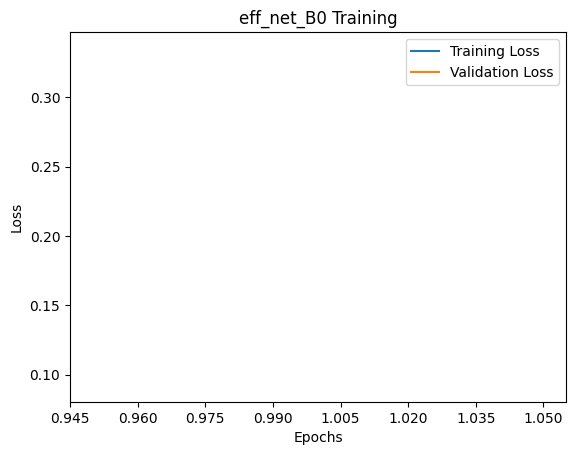

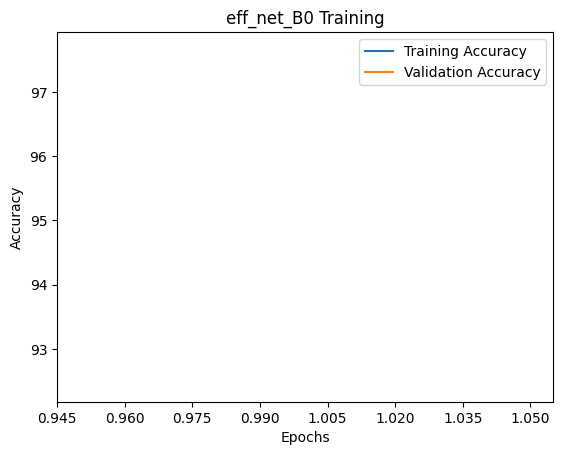

In [10]:
plot_history(
    history,
    metrics=['loss', 'acc'],
    labels=['Loss', 'Accuracy'],
    titles=f"{model_name} Training",
)

/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/poutyne/plotting.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


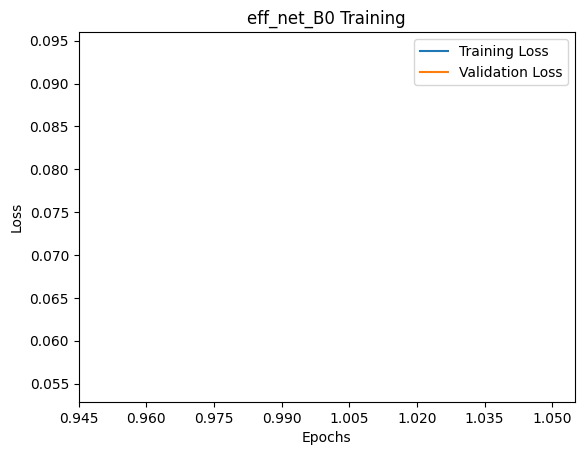

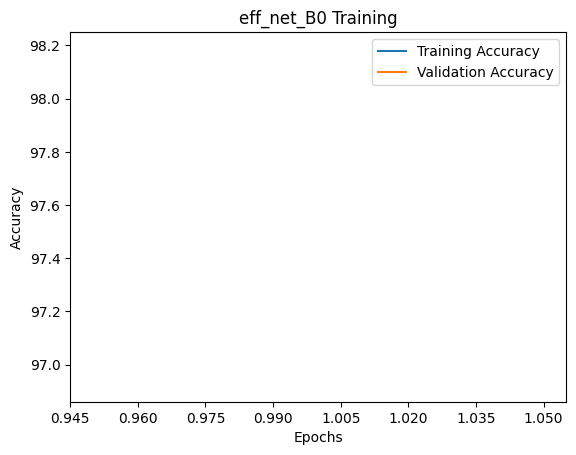

In [24]:
if save_logs == True:
    with open(f"{results_dir}/model_overview.txt", "w") as file:
        # Write the test metrics
        file.write(f"Test Loss: {test_metrics[0]}\n")  
        file.write(f"Test Acc: {test_metrics[1]}")
        file.write("\n\n")  # Add some space between sections

        # Write the model structure
        file.write("Model Structure\n")
        file.write(str(model))  # Convert the model to string and write to file
        file.write("\n\n")

        # Write the data transformations
        file.write("Training Data Transformations\n")
        file.write(str(train_transform))  # Convert the transform to string and write to file
        file.write("\n\n")

        file.write("Testing/Val Data Transformations\n")
        file.write(str(test_transform))  # Convert the transform to string and write to file
        file.write("\n\n")

        file.write(f"Using {device} device")


    # Check if the CSV file exists
    if os.path.exists("results/test_results.csv"):
        # Read the existing CSV file into a DataFrame
        test_results_df = pd.read_csv("results/test_results.csv")
    else:
        # If the file doesn't exist, create an empty DataFrame or initialize with test output columns
        test_results_df = pd.DataFrame(columns=[
        "model_id", "model", "epochs", "run_time", "test_loss", "test_acc", "lr", 
        "image_size", "rotate_angle", "horizontal_flip_prob", 
        "brightness_contrast", "gaussian_blur", "normalize"
        ])
        #  Add all thse to the test_results_df and in the new_results_dict
        # image_size = image_size,
        #                                        rotate_angle=rotate_angle,
        #                                        horizontal_flip_prob=horizontal_flip_prob,
        #                                        brightness_contrast=brightness_contrast,
        #                                        gaussian_blur=gaussian_blur,
        #                                        normalize=normalize,
    # Create a dictionary for the new results
    new_results_dict = {
        "model_id": [f"{model_name}_{timestamp}"],
        "model": [model_name],
        "epochs": [epochs],  
        "run_time": [run_time],  
        "test_loss": [test_metrics[0]],
        "test_acc": [test_metrics[1]],
        "lr": [lr],
        "image_size": [image_size],  
        "rotate_angle": [rotate_angle],  
        "horizontal_flip_prob": [horizontal_flip_prob],  
        "brightness_contrast": [brightness_contrast],  
        "gaussian_blur": [gaussian_blur],  
        "normalize": [normalize]  
    }


    new_rows_df = pd.DataFrame(new_results_dict)

    test_results_df = pd.concat([test_results_df, new_rows_df], ignore_index=True).fillna(value='None')


    test_results_df.to_csv("results/test_results.csv", index=False)


    # Plot the training history
    plot_history(
        history,
        metrics=['loss', 'acc'],
        labels=['Loss', 'Accuracy'],
        titles=f"{model_name} Training",
        save=True,  
        save_filename_template='{metric}_plot',  # Template for filenames
        save_directory=f"results/{model_name}_{timestamp}",  # Directory to save plots
        save_extensions=('png',)  # File extension(s)
    )




In [46]:
import configparser

# Create a ConfigParser instance
config = configparser.ConfigParser()

# Read the config file
config.read("config_files/config_1.txt")


config["settings"]["model_name"]

['config_files/config_1.txt']

In [47]:
config["settings"]["model_name"]

'efficientnet_b0'